In [3]:
from collections import defaultdict, namedtuple, Counter
import numpy as np
from os import listdir
from itertools import combinations
import scipy.stats as stats
import csv
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import json

In [4]:
phase_dirs = ['../phased_mssng_quads', 
              '../phased_ihart.ms2_quads', 
              '../phased_ssc.hg38']
identicals_files = ['../sibpair_similarity/mssng_quads_identicals.txt',
                   '../sibpair_similarity/ihart.ms2_quads_identicals.txt',
                   '../sibpair_similarity/ssc.hg38_identicals.txt']
ped_files = ['../../DATA/mssng/mssng.ped.quads.ped',
             '../../DATA/ihart.ms2/ihart.ped.quads.ped',
             '../../DATA/ssc.hg38/ssc.ped']
orig_ped_files = ['../../DATA/mssng/mssng.ped',
             '../../DATA/ihart.ms2/ihart.ped',
             '../../DATA/ssc.hg38/ssc.ped']
build = '38'
data_dirs = [['../../DATA/mssng/genotypes'],
             ['../../DATA/ihart.ms2/genotypes'],
             ['../../DATA/ssc.hg38/genotypes/phase1-1', '../../DATA/ssc.hg38/genotypes/phase1-2', 
              '../../DATA/ssc.hg38/genotypes/phase1-3', '../../DATA/ssc.hg38/genotypes/phase1-4', 
            '../../DATA/ssc.hg38/genotypes/phase1-5', 
            '../../DATA/ssc.hg38/genotypes/phase1-7', 
            '../../DATA/ssc.hg38/genotypes/phase2', 
            '../../DATA/ssc.hg38/genotypes/phase2_B01', 
            '../../DATA/ssc.hg38/genotypes/phase2_Replacements', 
            '../../DATA/ssc.hg38/genotypes/phase3_1', 
             '../../DATA/ssc.hg38/genotypes/phase3_1_B02', 
             '../../DATA/ssc.hg38/genotypes/phase3_2',
             #'../../DATA/ssc.hg38/genotypes/phase4',
             '../../DATA/ssc.hg38/genotypes/pilot', 
            ]]

In [5]:
chrom = '10'
if build == '37':
    #ctbp2_start_interval, ctbp2_end_interval = 127188569, 127688569
    ctbp2_start_interval, ctbp2_end_interval = 127188569, 128188569
    zeb1_start_interval, zeb1_end_interval = 31607424, 31818742
elif build == '38':
    #ctbp2_start_interval, ctbp2_end_interval = 125500000, 126000000
    ctbp2_start_interval, ctbp2_end_interval = 125500000, 126500000
    zeb1_start_interval, zeb1_end_interval = 31318417, 31529814


In [6]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
	return sample_to_affected, sample_to_sex

In [7]:
def pull_sample_to_multiplex(orig_ped_file):
    family_to_num_affected = defaultdict(int)
    family_to_inds = defaultdict(list)
    with open(orig_ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            family_to_inds[pieces[0]].append(pieces[1])
            if pieces[5]=='2':
                family_to_num_affected[pieces[0]] += 1
                
    sample_to_family_type = dict()
    for family, inds in family_to_inds.items():
        is_multiplex = family_to_num_affected[family] > 1
        for ind in inds:
            sample_to_family_type[ind] = 'multiplex' if is_multiplex else 'simplex'
    return sample_to_family_type
print(Counter(pull_sample_to_multiplex(orig_ped_files[0]).values()))

Counter({'simplex': 7551, 'multiplex': 2070})


In [8]:
Sibpair = namedtuple('Sibpair', ['family', 'sibling1', 'sibling2', 'mom', 'dad', 'phase_dir', 'num_affected', 'num_males', 'is_multiplex'])
def pull_sibpairs(phase_dir, identicals_file, sample_to_affected, sample_to_sex, sample_to_family_type):

	# pull identicals
	leave_out = set()
	with open(identicals_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			leave_out.update(pieces[1:])

	# pull individuals
	family_to_inds = defaultdict(list)
	sibpairs = list()
	for filename in listdir(phase_dir):
		if filename.endswith('.phased.txt'):
			family_key = filename[:-11]
			with open('%s/%s' % (phase_dir, filename), 'r')  as f:
				header = next(f).strip().split('\t')
				# check that we have a typical nuclear family structure
				if tuple(header[1:5]) == ('m1_del', 'm2_del', 'p1_del', 'p2_del'):
					individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]
					family_to_inds[family_key] = individuals
					for child1, child2 in combinations(individuals[2:], 2):
						if child1 not in leave_out and child2 not in leave_out and child1 in sample_to_affected and child2 in sample_to_affected:
							sibpairs.append(Sibpair(family_key, child1, child2, individuals[0], individuals[1], 
								phase_dir,
								int(sample_to_affected[child1]=='2')+int(sample_to_affected[child2]=='2'),
								int(sample_to_sex[child1]=='1')+int(sample_to_sex[child2]=='1'),
								sample_to_family_type[child1]=='multiplex'))
	sibpairs = sorted(sibpairs)

	assert len(sibpairs) == len(set(sibpairs)) # should have no duplicates
	return family_to_inds, sibpairs

In [82]:
RVCount = namedtuple('RVCount', ['z_aff', 'z_unaff', 'z_aff_mat', 'z_aff_pat', 'z_unaff_mat', 'z_unaff_pat'])
def pull_rvs(sibpairs, sample_to_affected, data_dirs, af_max=10**-4, af_min=10**-10, start_pos=ctbp2_start_interval, end_pos=ctbp2_end_interval):
    z_aff_mat, z_aff_pat, z_unaff_mat, z_unaff_pat = 0, 0, 0, 0
    z_aff, z_unaff = 0, 0
    
    for data_dir in data_dirs:
        with open('%s/samples.json' % data_dir, 'r') as f:
            samples = json.load(f)
        sample_to_index = dict([(x, i) for i, x in enumerate(samples)])

        has_autism = np.array([x in sample_to_affected and sample_to_affected[x]=='2' for x in samples])
        no_autism = np.array([x in sample_to_affected and sample_to_affected[x]=='1' for x in samples])
        #print(np.sum(has_autism), np.sum(no_autism))

        children = set()
        quad_children = set()
        aff_trios, typ_trios = [], []
        quads = []
        for sp in sibpairs:
            if sp.mom in sample_to_index and sp.dad in sample_to_index:
                mom_index, dad_index = sample_to_index[sp.mom], sample_to_index[sp.dad]
                if sp.num_affected==1 and sp.sibling1 in sample_to_index and sp.sibling2 in sample_to_index and (sp.sibling1 not in quad_children) and (sp.sibling2 not in quad_children):
                    if sample_to_affected[sp.sibling1]=='2':
                        quads.append([mom_index, dad_index, sample_to_index[sp.sibling1], sample_to_index[sp.sibling2]])
                    else:
                        quads.append([mom_index, dad_index, sample_to_index[sp.sibling2], sample_to_index[sp.sibling1]])
                    quad_children.add(sp.sibling1)
                    quad_children.add(sp.sibling2)
                if sp.sibling1 not in children and sp.sibling1 in sample_to_index:
                    if sample_to_affected[sp.sibling1]=='2': 
                        aff_trios.append([mom_index, dad_index, sample_to_index[sp.sibling1]])
                        children.add(sp.sibling1)
                    elif sample_to_affected[sp.sibling1]=='1':
                        typ_trios.append([mom_index, dad_index, sample_to_index[sp.sibling1]])
                        children.add(sp.sibling1)

                if sp.sibling2 not in children and sp.sibling2 in sample_to_index:
                    if sample_to_affected[sp.sibling2]=='2': 
                        aff_trios.append([mom_index, dad_index, sample_to_index[sp.sibling2]])
                        children.add(sp.sibling2)
                    elif sample_to_affected[sp.sibling2]=='1':
                        typ_trios.append([mom_index, dad_index, sample_to_index[sp.sibling2]])
                        children.add(sp.sibling2)        
        #print(len(aff_trios), len(typ_trios))
        print(len(quads))
        
        parent_indices = sorted(set([x[0] for x in quads]) | set([x[1] for x in quads]))

        aff_rvs = np.zeros((len(quads),), dtype=int)
        aff_rvs_mat = np.zeros((len(quads),), dtype=int)
        aff_rvs_pat = np.zeros((len(quads),), dtype=int)
        unaff_rvs = np.zeros((len(quads),), dtype=int)
        unaff_rvs_mat = np.zeros((len(quads),), dtype=int)
        unaff_rvs_pat = np.zeros((len(quads),), dtype=int)
        for i in range(14):
            try:
                coords = np.load('%s/chr.10.%d.gen.coordinates.npy' % (data_dir, i))
                af = np.load('%s/chr.10.%d.gen.af.npy' % (data_dir, i))
                indices = (coords[:, 1]>=start_pos) & (coords[:, 1]<=end_pos) & (coords[:, 2]==1) & (coords[:, 3]==1) & (af <= af_max) & (af > af_min)
                if np.sum(indices) > 0:
                    
                    gen = sparse.load_npz('%s/chr.10.%d.gen.npz' % (data_dir, i))
                    rvs = gen[:, indices].A
                    rvs_aff_trios = rvs[aff_trios, :]
                    rvs_typ_trios = rvs[typ_trios, :]
                    rvs_quads = rvs[quads, :]
                    #print(rvs.shape)
                    #print(rvs_aff_trios.shape, rvs_typ_trios.shape)

                    #aff_rvs += np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==0) & (rvs_quads[:, 2, :]==1), axis=1)
                    #aff_rvs += np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==2) & (rvs_quads[:, 2, :]==2), axis=1)
                    #aff_rvs += 2*np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 2, :]==2), axis=1)
                    #aff_rvs += np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 2, :]==1), axis=1)
                    #aff_rvs += np.sum((rvs_quads[:, 0, :]==0) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 2, :]==1), axis=1)
                    #aff_rvs += np.sum((rvs_quads[:, 0, :]==2) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 2, :]==2), axis=1)
                    aff_rvs += 2*np.sum(rvs_quads[:, 2, :]==2, axis=1)
                    aff_rvs += np.sum(rvs_quads[:, 2, :]==1, axis=1)
                    
                    #unaff_rvs += np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==0) & (rvs_quads[:, 3, :]==1), axis=1)
                    #unaff_rvs += np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==2) & (rvs_quads[:, 3, :]==2), axis=1)
                    #unaff_rvs += 2*np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 3, :]==2), axis=1)
                    #unaff_rvs += np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 3, :]==1), axis=1)
                    #unaff_rvs += np.sum((rvs_quads[:, 0, :]==0) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 3, :]==1), axis=1)
                    #unaff_rvs += np.sum((rvs_quads[:, 0, :]==2) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 3, :]==2), axis=1)
                    unaff_rvs += 2*np.sum(rvs_quads[:, 3, :]==2, axis=1)
                    unaff_rvs += np.sum(rvs_quads[:, 3, :]==1, axis=1)
                    
                    aff_rvs_mat += np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==0) & (rvs_quads[:, 2, :]==1), axis=1)
                    aff_rvs_mat += np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==2) & (rvs_quads[:, 2, :]==2), axis=1)
                    aff_rvs_pat += np.sum((rvs_quads[:, 0, :]==0) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 2, :]==1), axis=1)
                    aff_rvs_pat += np.sum((rvs_quads[:, 0, :]==2) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 2, :]==2), axis=1)
                    
                    unaff_rvs_mat += np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==0) & (rvs_quads[:, 3, :]==1), axis=1)
                    unaff_rvs_mat += np.sum((rvs_quads[:, 0, :]==1) & (rvs_quads[:, 1, :]==2) & (rvs_quads[:, 3, :]==2), axis=1)
                    unaff_rvs_pat += np.sum((rvs_quads[:, 0, :]==0) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 3, :]==1), axis=1)
                    unaff_rvs_pat += np.sum((rvs_quads[:, 0, :]==2) & (rvs_quads[:, 1, :]==1) & (rvs_quads[:, 3, :]==2), axis=1)
            except FileNotFoundError:
                pass
        
            
        z_aff += np.sum(aff_rvs > unaff_rvs)
        z_unaff += np.sum(unaff_rvs > aff_rvs)
        z_aff_mat += np.sum(aff_rvs_mat > unaff_rvs_mat)
        z_unaff_pat += np.sum(unaff_rvs_mat > aff_rvs_mat)
        z_aff_pat += np.sum(aff_rvs_pat > unaff_rvs_pat)
        z_unaff_mat += np.sum(unaff_rvs_pat > aff_rvs_pat)
    return RVCount(z_aff, z_unaff, z_aff_mat, z_aff_pat, z_unaff_mat, z_unaff_pat)
            

In [83]:
def run_tdt(rv_count):
    #print(rv_count)
    #print('all', 
    #      rv_count.x_aff/(rv_count.x_aff+rv_count.y_aff), 
    #      rv_count.x_unaff/(rv_count.x_unaff+rv_count.y_unaff),
    #      stats.chi2_contingency([[rv_count.x_aff, rv_count.y_aff], [rv_count.x_unaff, rv_count.y_unaff]])[1])
    #print('mat', 
    #      rv_count.x_aff_mat/(rv_count.x_aff_mat+rv_count.y_aff_mat), 
    #      rv_count.x_unaff_mat/(rv_count.x_unaff_mat+rv_count.y_unaff_mat),
    #       stats.chi2_contingency([[rv_count.x_aff_mat, rv_count.y_aff_mat], [rv_count.x_unaff_mat, rv_count.y_unaff_mat]])[1])
    #print('pat', 
    #      rv_count.x_aff_pat/(rv_count.x_aff_pat+rv_count.y_aff_pat), 
    #      rv_count.x_unaff_pat/(rv_count.x_unaff_pat+rv_count.y_unaff_pat),
    #      stats.chi2_contingency([[rv_count.x_aff_pat, rv_count.y_aff_pat], [rv_count.x_unaff_pat, rv_count.y_unaff_pat]])[1])
    print()   
    #print('trans aff mat vs pat', rv_count.x_aff_mat, rv_count.x_aff_pat, stats.binom_test(rv_count.x_aff_mat, rv_count.x_aff_mat+rv_count.x_aff_pat))
    #print('trans unaff mat vs pat', rv_count.x_unaff_mat, rv_count.x_unaff_pat, stats.binom_test(rv_count.x_unaff_mat, rv_count.x_unaff_mat+rv_count.x_unaff_pat))
    #print('notrans aff mat vs pat', rv_count.y_aff_mat, rv_count.y_aff_pat, stats.binom_test(rv_count.y_aff_mat, rv_count.y_aff_mat+rv_count.y_aff_pat))
    #print('notrans unaff mat vs pat', rv_count.y_unaff_mat, rv_count.y_unaff_pat, stats.binom_test(rv_count.y_unaff_mat, rv_count.y_unaff_mat+rv_count.y_unaff_pat))

    print('all', rv_count.z_aff, rv_count.z_unaff, stats.binom_test(rv_count.z_aff, rv_count.z_aff+rv_count.z_unaff))
    return stats.binom_test(rv_count.z_aff, rv_count.z_aff+rv_count.z_unaff), \
        stats.binom_test(rv_count.z_aff_mat, rv_count.z_aff_mat+rv_count.z_unaff_mat), \
        stats.binom_test(rv_count.z_aff_pat, rv_count.z_aff_pat+rv_count.z_unaff_pat), \
        rv_count.z_aff, rv_count.z_unaff

    

In [84]:
print(Counter([x for x in pull_sample_to_multiplex(orig_ped_files[2]).values()]))

Counter({'simplex': 9371})


In [85]:
intervals = [0.05, 0.01, 0.001, 0.0001, 0.00001]
pvalues = np.ones((len(phase_dirs), len(intervals)))
pvalues_mat = np.ones((len(phase_dirs), len(intervals)))
pvalues_pat = np.ones((len(phase_dirs), len(intervals)))
xs = np.zeros((len(phase_dirs), len(intervals)))
ys = np.zeros((len(phase_dirs), len(intervals)))
print(pvalues.shape)
for i, (phase_dir, identicals_file, ped_file, orig_ped_file, dds) in enumerate(zip(phase_dirs, identicals_files, ped_files, orig_ped_files, data_dirs)):
    print(phase_dir)
    sample_to_affected, sample_to_sex = pull_phenotype_ped(ped_file)
    sample_to_family_type = pull_sample_to_multiplex(orig_ped_file)
    family_to_inds, sibpairs = pull_sibpairs(phase_dir, identicals_file, sample_to_affected, sample_to_sex, sample_to_family_type)
    print(Counter([x.is_multiplex for x in sibpairs]))
    
    for j in range(len(intervals)-1):
        rv_count = pull_rvs(sibpairs, sample_to_affected, dds, af_max=intervals[j], af_min=intervals[j+1])
        p, p_mat, p_pat, x, y = run_tdt(rv_count)
        pvalues[i, j] = p
        pvalues_mat[i, j] = p_mat
        pvalues_pat[i, j] = p_pat
        xs[i, j] = x
        ys[i, j] = y
        

(3, 5)
../phased_mssng_quads
Counter({True: 539, False: 188})
145

all 67 59 0.5330527502675563
145

all 61 66 0.7227870831457853
145

all 51 71 0.08498064582685326
145

all 55 64 0.46348817662276387
../phased_ihart.ms2_quads
Counter({True: 1902, False: 3})
402

all 170 183 0.523079498404589
402

all 166 168 0.9563743653626198
402

all 154 141 0.48482391340149333
402

all 166 170 0.8700273538364552
../phased_ssc.hg38
Counter({False: 1926})
100
100
100
100
79
13
588
90
6
443
41
226
40

all 949 885 0.14124423919109708
100
100
100
100
79
13
588
90
6
443
41
226
40

all 920 891 0.5105755505851061
100
100
100
100
79
13
588
90
6
443
41
226
40

all 790 818 0.5007566463863128
100
100
100
100
79
13
588
90
6
443
41
226
40

all 687 779 0.017438523050607


Counter({True: 1902, False: 3})


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in log10


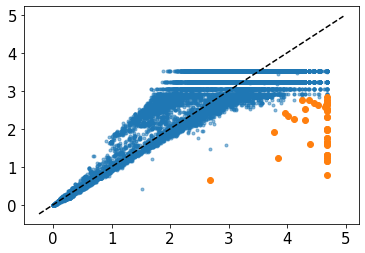

In [218]:
phase_dir, identicals_file, ped_file, orig_ped_file, dds = phase_dirs[1], identicals_files[1], ped_files[1], orig_ped_files[1], data_dirs[1]

sample_to_affected, sample_to_sex = pull_phenotype_ped(ped_file)
sample_to_family_type = pull_sample_to_multiplex(orig_ped_file)
family_to_inds, sibpairs = pull_sibpairs(phase_dir, identicals_file, sample_to_affected, sample_to_sex, sample_to_family_type)
print(Counter([x.is_multiplex for x in sibpairs]))

i = 12
coords = np.load('%s/chr.10.%d.gen.coordinates.npy' % (dds[0], i))
af = np.load('%s/chr.10.%d.gen.af.npy' % (dds[0], i))
gen = sparse.load_npz('%s/chr.10.%d.gen.npz' % (dds[0], i))

with open('%s/samples.json' % dds[0], 'r') as f:
    samples = json.load(f)
sample_to_index = dict([(x, i) for i, x in enumerate(samples)])
parent_indices = set()
quads, quad_children = [], set()
aff_trios, typ_trios, children = [], [], set()
for sp in sibpairs:
    if sp.mom in sample_to_index:
        parent_indices.add(sample_to_index[sp.mom])
    if sp.dad in sample_to_index:
        parent_indices.add(sample_to_index[sp.dad])
        
    if sp.mom in sample_to_index and sp.dad in sample_to_index:
        mom_index, dad_index = sample_to_index[sp.mom], sample_to_index[sp.dad]
        if sp.num_affected==1 and sp.sibling1 in sample_to_index and sp.sibling2 in sample_to_index and (sp.sibling1 not in quad_children) and (sp.sibling2 not in quad_children):
            if sample_to_affected[sp.sibling1]=='2':
                quads.append([mom_index, dad_index, sample_to_index[sp.sibling1], sample_to_index[sp.sibling2]])
            else:
                quads.append([mom_index, dad_index, sample_to_index[sp.sibling2], sample_to_index[sp.sibling1]])
            quad_children.add(sp.sibling1)
            quad_children.add(sp.sibling2)
    if sp.sibling1 not in children and sp.sibling1 in sample_to_index:
        if sample_to_affected[sp.sibling1]=='2': 
            aff_trios.append([mom_index, dad_index, sample_to_index[sp.sibling1]])
            children.add(sp.sibling1)
        elif sample_to_affected[sp.sibling1]=='1':
            typ_trios.append([mom_index, dad_index, sample_to_index[sp.sibling1]])
            children.add(sp.sibling1)

    if sp.sibling2 not in children and sp.sibling2 in sample_to_index:
        if sample_to_affected[sp.sibling2]=='2': 
            aff_trios.append([mom_index, dad_index, sample_to_index[sp.sibling2]])
            children.add(sp.sibling2)
        elif sample_to_affected[sp.sibling2]=='1':
            typ_trios.append([mom_index, dad_index, sample_to_index[sp.sibling2]])
            children.add(sp.sibling2)

parent_indices = sorted(parent_indices)

plot_indices = (coords[:, 1]>=ctbp2_start_interval) & (coords[:, 1]<=ctbp2_end_interval) & (coords[:, 2]==1) & (coords[:, 3]==1)
parental_af = (np.sum(gen[:, plot_indices].A[parent_indices, :]==1, axis=0)+2*np.sum(gen[:, plot_indices].A[parent_indices, :]==2, axis=0))/(2*np.sum(gen[:, plot_indices].A[parent_indices, :]!=-1, axis=0))
plt.scatter(-np.log10(af[plot_indices]), -np.log10(parental_af), alpha=0.5, marker='.')
outliers = (np.abs(-np.log10(af[plot_indices])+np.log10(parental_af))>1.5) & (parental_af > 5/(2*len(parent_indices)))
plt.scatter(-np.log10(af[plot_indices][outliers]), -np.log10(parental_af[outliers]))
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.show()



In [ ]:
ihart_outliers = coords[plot_indices, 1][outliers]

In [ ]:
mssng_outliers = coords[plot_indices, 1][outliers]

In [134]:
print(ihart_outliers)
print(mssng_outliers)
print(set(ihart_outliers) & set(mssng_outliers))

[125569189 125569358 125569438 125636160 125834787 125888855 125889763
 125892110 125892678 125892798 125896372 125903099 125906520 125906524
 125906526 125906527 125918557 125918560 125918563 125919198 125936437
 125964189 125964190 126004165 126004166 126057415 126086434 126086438
 126095536 126159315 126174012 126174016 126174022 126178418 126191002
 126193274 126194282 126312135 126358179 126398763 126404764 126404765
 126431099]
[125512515 125512657 125512658 125512678 125512679 125512686 125512688
 125558490 125565875 125569227 125590123 125590128 125612806 125679113
 125703758 125703791 125703794 125790642 125832829 125834787 125834790
 125834907 125847719 125862449 125867762 125878728 125878730 125881175
 125881177 125900375 125900376 125904454 125909535 125911024 125924531
 125936398 125939938 125951254 125956232 125969347 126023928 126057415
 126057416 126152048 126152573 126206892 126250579 126286001 126304292
 126321927 126398790 126448004 126470764]
{125834787, 126057415}


In [158]:
outlier_index = np.where(coords[plot_indices, 1][outliers]==125834787)[0][0]
print(outlier_index)

19


(1733, 3, 23681) (412, 3, 23681)


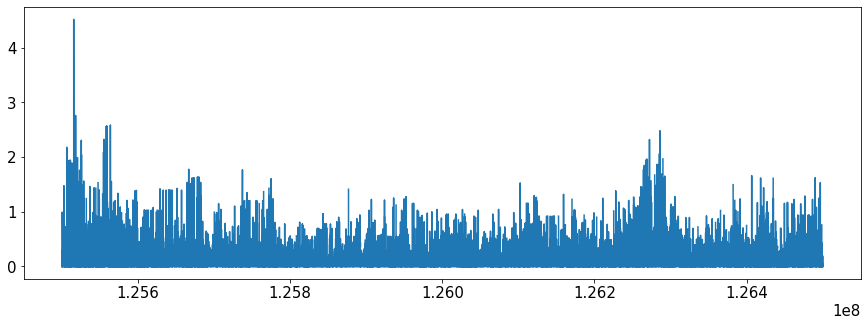

In [219]:
rvs = gen[:, plot_indices].A
rvs_aff = rvs[aff_trios, :]
rvs_typ = rvs[typ_trios, :]
print(rvs_aff.shape, rvs_typ.shape)

aff_trans = np.sum((rvs_aff[:, 0, :]==1) & (rvs_aff[:, 1, :]==0) & (rvs_aff[:, 2, :]==1), axis=0)
aff_trans += np.sum((rvs_aff[:, 0, :]==0) & (rvs_aff[:, 1, :]==1) & (rvs_aff[:, 2, :]==1), axis=0)
aff_trans += 2*np.sum((rvs_aff[:, 0, :]==1) & (rvs_aff[:, 1, :]==1) & (rvs_aff[:, 2, :]==2), axis=0)
aff_trans += np.sum((rvs_aff[:, 0, :]==1) & (rvs_aff[:, 1, :]==1) & (rvs_aff[:, 2, :]==1), axis=0)
aff_trans += np.sum((rvs_aff[:, 0, :]==1) & (rvs_aff[:, 1, :]==2) & (rvs_aff[:, 2, :]==2), axis=0)
aff_trans += np.sum((rvs_aff[:, 0, :]==2) & (rvs_aff[:, 1, :]==1) & (rvs_aff[:, 2, :]==2), axis=0)

aff_notrans = np.sum((rvs_aff[:, 0, :]==1) & (rvs_aff[:, 1, :]==0) & (rvs_aff[:, 2, :]==0), axis=0)
aff_notrans += np.sum((rvs_aff[:, 0, :]==0) & (rvs_aff[:, 1, :]==1) & (rvs_aff[:, 2, :]==0), axis=0)
aff_notrans += 2*np.sum((rvs_aff[:, 0, :]==1) & (rvs_aff[:, 1, :]==1) & (rvs_aff[:, 2, :]==0), axis=0)
aff_notrans += np.sum((rvs_aff[:, 0, :]==1) & (rvs_aff[:, 1, :]==1) & (rvs_aff[:, 2, :]==1), axis=0)
aff_notrans += np.sum((rvs_aff[:, 0, :]==1) & (rvs_aff[:, 1, :]==2) & (rvs_aff[:, 2, :]==1), axis=0)
aff_notrans += np.sum((rvs_aff[:, 0, :]==2) & (rvs_aff[:, 1, :]==1) & (rvs_aff[:, 2, :]==1), axis=0)

typ_trans = np.sum((rvs_typ[:, 0, :]==1) & (rvs_typ[:, 1, :]==0) & (rvs_typ[:, 2, :]==1), axis=0)
typ_trans += np.sum((rvs_typ[:, 0, :]==0) & (rvs_typ[:, 1, :]==1) & (rvs_typ[:, 2, :]==1), axis=0)
typ_trans += 2*np.sum((rvs_typ[:, 0, :]==1) & (rvs_typ[:, 1, :]==1) & (rvs_typ[:, 2, :]==2), axis=0)
typ_trans += np.sum((rvs_typ[:, 0, :]==1) & (rvs_typ[:, 1, :]==1) & (rvs_typ[:, 2, :]==1), axis=0)
typ_trans += np.sum((rvs_typ[:, 0, :]==1) & (rvs_typ[:, 1, :]==2) & (rvs_typ[:, 2, :]==2), axis=0)
typ_trans += np.sum((rvs_typ[:, 0, :]==2) & (rvs_typ[:, 1, :]==1) & (rvs_typ[:, 2, :]==2), axis=0)

typ_notrans = np.sum((rvs_typ[:, 0, :]==1) & (rvs_typ[:, 1, :]==0) & (rvs_typ[:, 2, :]==0), axis=0)
typ_notrans += np.sum((rvs_typ[:, 0, :]==0) & (rvs_typ[:, 1, :]==1) & (rvs_typ[:, 2, :]==0), axis=0)
typ_notrans += 2*np.sum((rvs_typ[:, 0, :]==1) & (rvs_typ[:, 1, :]==1) & (rvs_typ[:, 2, :]==0), axis=0)
typ_notrans += np.sum((rvs_typ[:, 0, :]==1) & (rvs_typ[:, 1, :]==1) & (rvs_typ[:, 2, :]==1), axis=0)
typ_notrans += np.sum((rvs_typ[:, 0, :]==1) & (rvs_typ[:, 1, :]==2) & (rvs_typ[:, 2, :]==1), axis=0)
typ_notrans += np.sum((rvs_typ[:, 0, :]==2) & (rvs_typ[:, 1, :]==1) & (rvs_typ[:, 2, :]==1), axis=0)
#print(aff_trans, aff_notrans)
tdt_pvalues = np.ones((aff_trans.shape[0], 3))
for j in range(aff_trans.shape[0]):
    tdt_pvalues[j, 0] = stats.binom_test(aff_trans[j], aff_trans[j]+aff_notrans[j])
    tdt_pvalues[j, 1] = stats.binom_test(typ_trans[j], typ_trans[j]+typ_notrans[j])
    try:
        tdt_pvalues[j, 2] = stats.chi2_contingency([[aff_trans[j], aff_notrans[j]], 
                                                    [typ_trans[j], typ_notrans[j]]])[1]
    except:
        pass
plt.figure(figsize=(15, 5))
#plt.plot(coords[plot_indices, 1][outliers], -np.log10(tdt_pvalues[:, 0]))
#plt.plot(coords[plot_indices, 1][outliers], -np.log10(tdt_pvalues[:, 1]))
plt.plot(coords[plot_indices, 1], -np.log10(tdt_pvalues[:, 2]))
plt.show()

In [220]:
peak_indices = (coords[plot_indices, 1]>=126050000) & (coords[plot_indices, 1]<=126060000)# & (-np.log10(tdt_pvalues[:, 2])>2)
print(typ_trans[peak_indices])



[  0   1  96   1   0 213   2   0   1   0  96   1   1   1   0   1   0   0
   0 114   0   0 216 216   0   0   4   0   0   0   0   0 216   0   0   1
  98   0   0   0   0 224 175   0   4 178   0   0   0   1  96   0   0   0
   1   1   1   0   0 211   0  96 211 211   1 199   0 216   0   0   0   0
   0   0   0   0   9   0   0  41   1   0   0   0   0   0   1   0   0  41
   1   0 146   0   0 212   0   0  41 162   4   0   0   0   0   3   0   4
   4 200   0   0   0   0   0   0   0 162   7   4   0 162   0 212   0   2
   0   0   0 206   0 212   2   3   0   0 212   2   0   0   0   2   0  78
 201 201   1   1   0  96   0   0   1 200   0   0   2   0   0 212   1   0
  47   1   7   2   2   0 217 210 216   0  18   0   0 199   0   0   1   4
 216   1   0 215   0 216   2 213   0   2   0   0   0   0   0   3 215   0
   0   0 215   0 216   0   2   0   0   0  25 218   0   0   1   1   2 202
 202   0 114   0 216   1   0   0   1   1   2   1]


(array([0.05487547, 0.02216125, 0.01055298, 0.00158295, 0.00052765,
        0.03429717, 0.01952301, 0.00844238, 0.04485015, 0.0205783 ]),
 array([ 0. ,  4.6,  9.2, 13.8, 18.4, 23. , 27.6, 32.2, 36.8, 41.4, 46. ]),
 <a list of 10 Patch objects>)

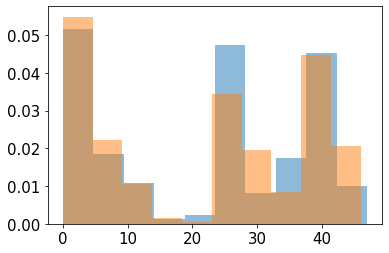

In [221]:
plt.hist(np.sum(rvs_aff[:, 2, peak_indices]==1, axis=1), alpha=0.5, density=True)
plt.hist(np.sum(rvs_typ[:, 2, peak_indices]==1, axis=1), alpha=0.5, density=True)

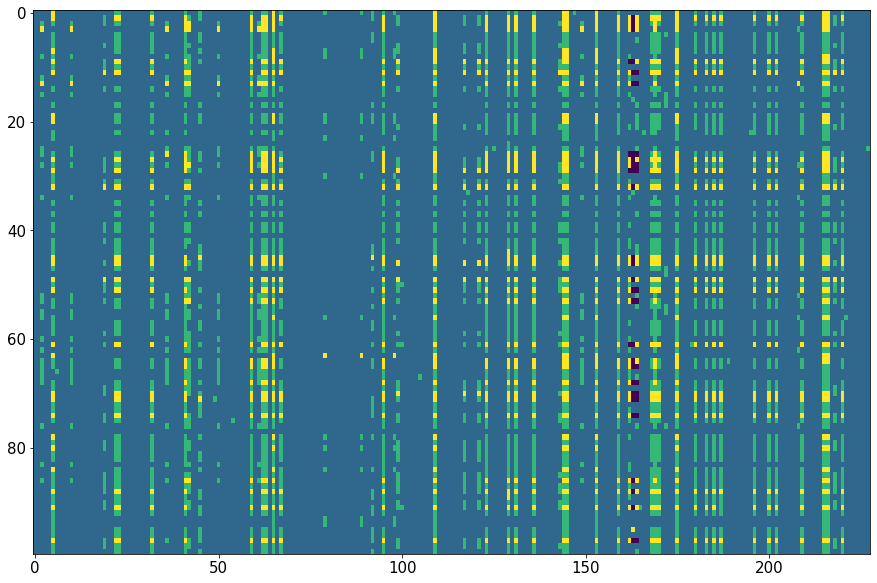

In [222]:
plt.figure(figsize=(15, 10))
plt.imshow(rvs_typ[:100, 2, peak_indices], aspect='auto')
plt.show()

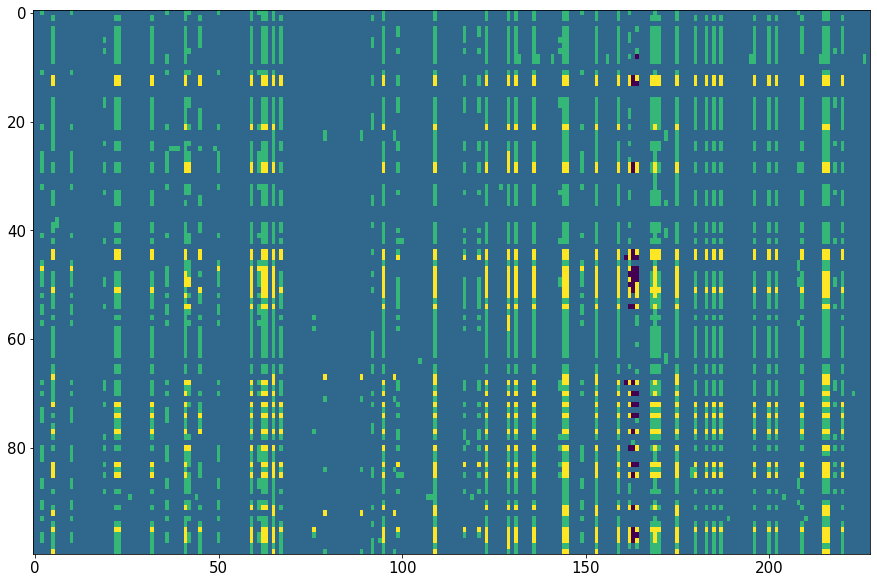

In [223]:
plt.figure(figsize=(15, 10))
plt.imshow(rvs_aff[100:200, 2, peak_indices], aspect='auto')
plt.show()

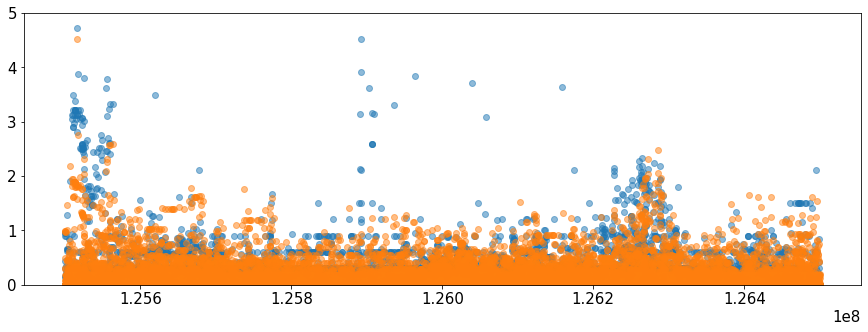

In [224]:
plt.figure(figsize=(15, 5))
#plt.plot(coords[plot_indices, 1][outliers], -np.log10(tdt_pvalues[:, 0]))
#plt.plot(coords[plot_indices, 1][outliers], -np.log10(tdt_pvalues[:, 1]))
#plt.scatter(coords[plot_indices, 1], -np.log10(tdt_pvalues[:, 0]))
plt.scatter(coords[plot_indices, 1], -np.log10(tdt_pvalues[:, 1]), alpha=0.5)
plt.scatter(coords[plot_indices, 1], -np.log10(tdt_pvalues[:, 2]), alpha=0.5)
#plt.xlim([126050000, 126060000])
plt.ylim([0, 5])
plt.show()

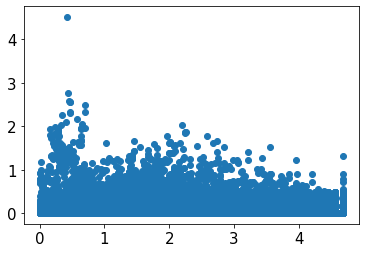

In [229]:
plt.scatter(-np.log10(af[plot_indices]), -np.log10(tdt_pvalues[:, 2]))

In [228]:
print(np.unique(rvs_aff[:, :, outlier_index], return_counts=True, axis=0))
print(aff_trans[outlier_index], aff_notrans[outlier_index])
print(typ_trans[outlier_index], typ_notrans[outlier_index])
print(stats.chi2_contingency([[aff_trans[outlier_index], aff_notrans[outlier_index]], [typ_trans[outlier_index], typ_notrans[outlier_index]]]))



(array([[0, 0, 0],
       [0, 1, 1],
       [1, 0, 0]], dtype=int8), array([1727,    2,    4]))
2 4
1 2
(0.0, 1.0, 1, array([[2., 4.],
       [1., 2.]]))


In [13]:
def exact_confidence_interval(count, n, p):
    p_hat = count/n
    alpha = 0.05
    ps = np.arange(0, 1, 0.0001)

    conf = np.zeros((2, len(count)))
    for i in range(len(count)):
        conf[0, i] = p_hat[i] - ps[np.searchsorted(-stats.binom.cdf(count[i]-1, n[i], ps), -(1 - alpha/2))]
        conf[1, i] = ps[np.searchsorted(-stats.binom.cdf(count[i], n[i], ps), -alpha/2)] - p_hat[i]
        print(i, p_hat[i], conf[:, i], stats.binom_test(count[i], n[i], p=p))
    return p_hat, conf

#print(exact_confidence_interval(both_counts, n))


In [17]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
colors = ['#695d46ff', '#ce93d8ff', '#ef6c00ff', '#4db6acff']

width = 0.2
def plot_with_error(counts, n, x, color, label, p=0.5):
    p_hat, conf = exact_confidence_interval(counts[n!=0], n[n!=0], p=p)
    plt.bar(x[n!=0], p_hat, width, 
                 color=color, label=label)
    plt.errorbar(x[n!=0], p_hat, yerr=conf, 
                 color='black', linestyle='', capsize=5)

0 0.5317460317460317 [0.09084603 0.08945397] 0.5330527502675563
1 0.48031496062992124 [0.08941496 0.09048504] 0.7227870831457853
2 0.4180327868852459 [0.08863279 0.09276721] 0.08498064582685326
3 0.46218487394957986 [0.09178487 0.09381513] 0.46348817662276387
0 0.48158640226628896 [0.0531864 0.0535136] 0.523079498404589
1 0.49700598802395207 [0.05480599 0.05499401] 0.9563743653626198
2 0.5220338983050847 [0.0586339 0.0582661] 0.48482391340149333
3 0.49404761904761907 [0.05464762 0.05485238] 0.8700273538364552
0 0.5174482006543075 [0.0231482 0.0231518] 0.14124423919109708
1 0.5080066261733849 [0.02320663 0.02329337] 0.5105755505851061
2 0.49129353233830847 [0.02469353 0.02480647] 0.5007566463863128
3 0.4686221009549795 [0.0257221 0.0259779] 0.017438523050607


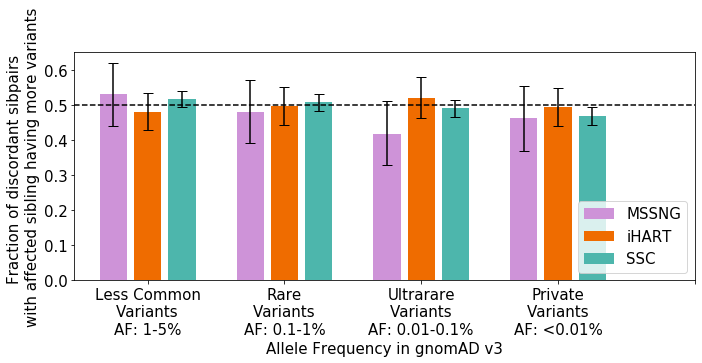

In [26]:
plt.figure(figsize=(10, 5))

plot_with_error(xs[0, :], xs[0, :]+ys[0, :], np.arange(len(intervals)), colors[1], 'MSSNG')
plot_with_error(xs[1, :], xs[1, :]+ys[1, :], np.arange(len(intervals))+1.25*width, colors[2], 'iHART')
plot_with_error(xs[2, :], xs[2, :]+ys[2, :], np.arange(len(intervals))+2.5*width, colors[3], 'SSC')

plt.xticks(np.arange(len(intervals))+1.25*width, ['Less Common\nVariants\nAF: 1-5%', 'Rare\nVariants\nAF: 0.1-1%', 'Ultrarare\nVariants\nAF: 0.01-0.1%', 'Private\nVariants\nAF: <0.01%'])
plt.axhline(0.5, color='black', linestyle='--')
#plt.ylabel('-log10(pvalue)')
plt.xlabel('Allele Frequency in gnomAD v3')
plt.ylabel('Fraction of discordant sibpairs \nwith affected sibling having more variants')
plt.legend()
plt.tight_layout()
plt.show()